In [1]:
from IPython.display import clear_output

In [2]:
!pip install bokeh datashader holoviews shap skope_rules umap-learn
clear_output()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import six
import sys

sys.modules['sklearn.externals.six'] = six

from lightgbm import LGBMClassifier
from shap import Explainer
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from skrules import SkopeRules
from umap import UMAP
from umap.plot import points

In [12]:
plt.rcParams['figure.figsize'] = (14, 7)

In [4]:
# simulate raw data
X, y = make_classification(
    n_samples=1000,
    n_features=50,
    n_informative=5,
    n_classes=2,
    n_clusters_per_class=3,
    shuffle=False
)

In [5]:
# fit a GBT model to the data
model = LGBMClassifier()

In [6]:
model.fit(X, y)

LGBMClassifier()

In [7]:
# compute SHAP values
explainer = Explainer(model)

In [8]:
shap_values = explainer(X)

In [9]:
# compute 2D embedding of raw variable values
X_mapper = UMAP(
  n_components=2, n_neighbors=200, min_dist=0
).fit(X)
X_2d = X_mapper.transform(X)

# compute 2D embedding of SHAP values
s_mapper = UMAP(
  n_components=2, n_neighbors=200, min_dist=0
).fit(shap_values.values[:, :, 1])
s_2d = s_mapper.transform(shap_values.values[:, :, 1])

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.


Text(0.5, 1.0, 'SHAP values')

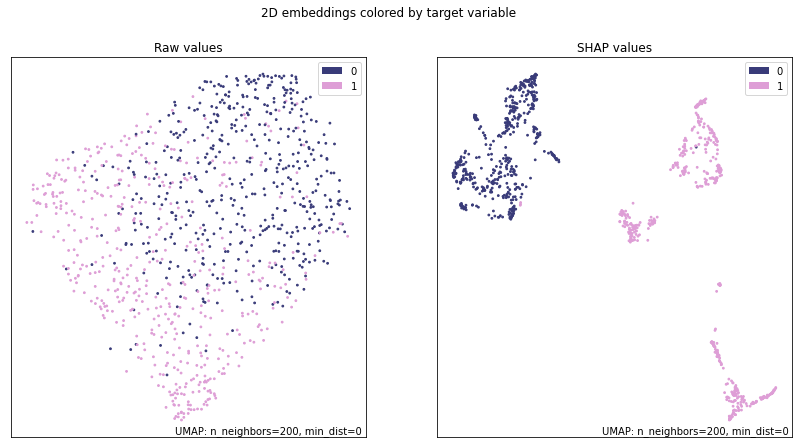

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('2D embeddings colored by target variable')
points(X_mapper, labels=y, theme='red', ax=ax1)
points(s_mapper, labels=y, theme='red', ax=ax2)
ax1.set_title('Raw values')
ax2.set_title('SHAP values')

In [28]:
db = DBSCAN(eps=1.5, min_samples=20).fit(s_2d)

In [29]:
s_labels = db.labels_

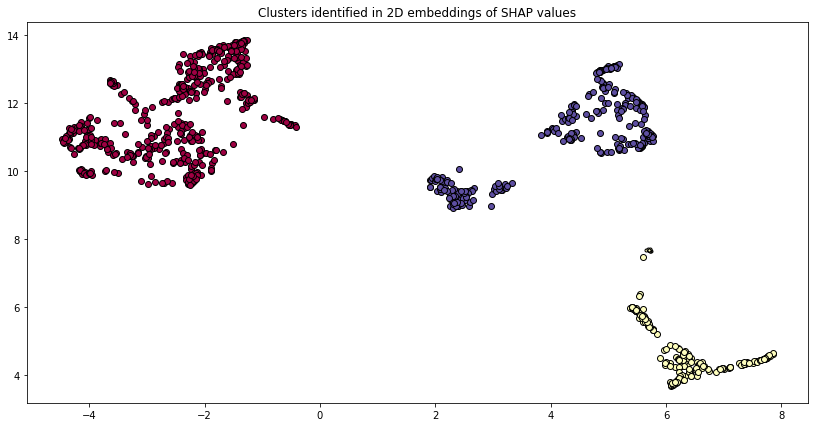

In [30]:
core_samples_mask = np.zeros_like(s_labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Black removed and is used for noise instead.
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(set(s_labels)))]

for k, col in zip(set(s_labels), colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = s_labels == k

    xy = s_2d[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=6,
    )

    xy = s_2d[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=3,
    )

plt.title('Clusters identified in 2D embeddings of SHAP values')
plt.show()

In [31]:
for cluster in np.unique(s_labels):
    # create target variable for individual cluster
    yc = (s_labels == cluster) * 1
    # use SkopeRules to identify rules with a maximum of two comparison terms
    sr = SkopeRules(max_depth=2).fit(X, yc)
    # print best decision rule
    print(cluster, sr.rules_[0][0])
    # print precision and recall of best decision rule
    print(f"Precision: {sr.rules_[0][1][0]:.2f}, \
        Recall: {sr.rules_[0][1][1]:.2f}\n")

0 __C__4 <= 0.9091421067714691 and __C__5 > -0.08273791894316673
Precision: 0.80,         Recall: 0.82

1 __C__4 > 0.9091421067714691 and __C__5 <= 2.768641233444214
Precision: 0.90,         Recall: 0.96

2 __C__4 <= 0.8961755037307739 and __C__5 <= -0.6920249760150909
Precision: 0.83,         Recall: 0.55

